# Experiment 1: scaling of performance with data

For reference, the original paper is [here](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

For the first experiment, we're just going to subsample the data and see how peformance changes as we increase the training set size.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import math

%matplotlib inline
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

import pickle
import altair
import scipy

import glob
import re

from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Helper functions

In [3]:
def get_dataset_size(start = 0.5, end = 100, base=2):
    """ Returns exponentially distributed dataset size vector"""
    dataset_size=[start]
    while True:
        dataset_size.append(dataset_size[-1]*base)
        if dataset_size[-1] > end:
            dataset_size[-1] = end
            break
    
    return dataset_size


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    

### Our simple ConvNet

In [59]:
class Net(nn.Module):
    def __init__(self, hyperparam_dict=None):
        
        super(Net, self).__init__()
        
        if not hyperparam_dict :
            hyperparam_dict = self.standard_hyperparams()
        
        self.hyperparam_dict = hyperparam_dict
        
        self.conv1 = nn.Conv2d(3, hyperparam_dict['conv1_size'], 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hyperparam_dict['conv1_size'], hyperparam_dict['conv2_size'], 5)
        self.fc1 = nn.Linear(hyperparam_dict['conv2_size'] * 5 * 5, hyperparam_dict['fc1_size'])
        self.fc2 = nn.Linear(hyperparam_dict['fc1_size'], hyperparam_dict['fc2_size'])
        self.fc3 = nn.Linear(hyperparam_dict['fc2_size'], 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.size())
        x = x.view(-1, self.hyperparam_dict['conv2_size'] * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def standard_hyperparams(self):
        hyperparam_dict = {}
        
        hyperparam_dict['conv1_size'] = 6
        hyperparam_dict['conv2_size'] = 16
        
        hyperparam_dict['fc1_size'] = 120
        hyperparam_dict['fc2_size'] = 84
        
        return hyperparam_dict
        



In [73]:
class DeeperNet(nn.Module):
    def __init__(self, hyperparam_dict=None):
        
        super(DeeperNet, self).__init__()
        
        if not hyperparam_dict :
            hyperparam_dict = self.standard_hyperparams()
        
        self.hyperparam_dict = hyperparam_dict
        self.pool = nn.MaxPool2d(2, 2)        
        self.conv1 = nn.Conv2d(3, hyperparam_dict['conv1_size'], 5)
        self.conv2 = nn.Conv2d(hyperparam_dict['conv1_size'], hyperparam_dict['conv2_size'], 5)
        self.conv3 = nn.Conv2d(hyperparam_dict['conv2_size'], hyperparam_dict['conv3_size'], 2)
        self.conv4 = nn.Conv2d(hyperparam_dict['conv3_size'], hyperparam_dict['conv4_size'], 2)
        self.conv5 = nn.Conv2d(hyperparam_dict['conv4_size'], hyperparam_dict['conv5_size'], 2)
        self.conv6 = nn.Conv2d(hyperparam_dict['conv5_size'], hyperparam_dict['conv6_size'], 2)
        self.fc1 = nn.Linear(hyperparam_dict['conv6_size'], hyperparam_dict['fc1_size'])
        self.fc2 = nn.Linear(hyperparam_dict['fc1_size'], hyperparam_dict['fc2_size'])
        self.fc3 = nn.Linear(hyperparam_dict['fc2_size'], 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1, self.hyperparam_dict['conv6_size'])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def standard_hyperparams(self):
        hyperparam_dict = {}
        
        hyperparam_dict['conv1_size'] = 6
        hyperparam_dict['conv2_size'] = 16
        hyperparam_dict['conv3_size'] = 32
        hyperparam_dict['conv4_size'] = 32
        hyperparam_dict['conv5_size'] = 64
        hyperparam_dict['conv6_size'] = 128
        
        hyperparam_dict['fc1_size'] = 120
        hyperparam_dict['fc2_size'] = 84
        
        return hyperparam_dict

### Model training and testing

In [69]:
def train_model(net, trainloader, valloader, n_val, n_epochs=10, lr=0.001, momentum=0.9, weight_decay=0.1):
    """ Take a model, run some number of training steps on some data.
    """
    print('Inside training, model ID', id(net))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) 

    train_loss_list = []
    val_loss_list = []
    
    best_val_loss=10
    for epoch in range(n_epochs):  
        if epoch > 4 and (val_loss_list[-1] > val_loss_list[-2]) and (val_loss_list[-2] > val_loss_list[-3]) and (val_loss_list[-3] > val_loss_list[-4]):
            break
        epoch_start = time.time()
        running_loss = 0.0
        val_loss = 0.0
        for i_train, data in enumerate(trainloader, 0):
            
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
                

        eval_start = time.time()
        
        for i_val, data in enumerate(valloader, 0):
        
            if i_val> n_val:
                    break

            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # get output
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            val_loss += loss.data[0]

            
        train_loss_list.append(running_loss/i_train)
        val_loss_list.append(val_loss/i_val)
        print("Epoch %d done, avg_train_loss=%1.2f, avg_val_loss=%1.2f, batches=%d \n Took %1.2f minutes for training, %1.2f for eval."
              %(epoch, running_loss/i_train, val_loss/i_val, i_train, (eval_start-epoch_start)/60, (time.time() - eval_start)/60))
        
        if val_loss/i_val < best_val_loss:
            print('Found better model')
            saved_net = net
            best_val_loss = val_loss/i_val
            
    print('Finished Training')
    
    # Return the net with the best loss
    print('Returning net with %1.3f loss'%best_val_loss)
    return saved_net, train_loss_list, val_loss_list

def test_model(net, testloader):
    """ Test a model on a dataset."""
    
    print('Test UID is', id(net))
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss=0
    for data in testloader:
        inputs, orig_labels = data
        inputs, labels = Variable(inputs), Variable(orig_labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == orig_labels).sum()
        total_loss += loss.data[0]
    
    return correct/total, total_loss/total

def test_saved_model(dataset_size):
    """ Load a trained model and test it for a list of dataset sizes."""

    test_acc = {}
    val_acc = {}
    train_acc = {}
    test_loss = {}
    for train_size in dataset_size:
        net = torch.load('trainset_%1.2f_%d_images.model'%(train_size, train_size*total_train))
        print('Loaded model with subset %1.4f, which is %d images'%(train_size, train_size*total_train))

        accuracy, loss = test_model(net, testloader)

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * accuracy))

        test_acc[train_size] = accuracy
        test_loss[train_size] = loss

        del net # Attempt to free-up memory!
        
    return test_acc, test_loss

def test_best_saved_model(dataset_size, regexp='trainset_%d_images*.model'):
    """ Retrieve the saved model with the best validation score."""

    test_acc = {}
    val_acc = {}
    train_acc = {}
    test_loss = {}

    for train_size in dataset_size:
        
        candidates = glob.glob(regexp%(train_size*total_train))

        best_model = sorted(candidates, key = lambda  str: re.sub(".*loss", "", str))[0]
        
        net = torch.load(best_model)
        print('Loaded model %s' %(best_model))

        accuracy, loss = test_model(net, testloader)

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * accuracy))

        test_acc[train_size] = accuracy
        test_loss[train_size] = loss

        del net # Attempt to free-up memory!
        
    return test_acc, test_loss

def plot_results(test_acc, test_loss):
    """ Plot dataset size vs accuracy and loss"""
    
    plt.figure(figsize=(15,7))
    plt.style.use('seaborn-whitegrid')

    plt.subplot(121)
    plt.plot(dataset_size*total_train, list(test_acc.values()), color='g', linewidth=2, marker='x', markersize=8)
    plt.xlabel('Training Examples', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)

    plt.subplot(122)
    ax = plt.loglog()
    plt.plot(dataset_size*total_train, list(test_acc.values()), color='g', linewidth=2, marker='x', markersize=8)
    plt.xlabel('log(Training Examples)', fontsize=20)
    plt.ylabel('log Accuracy', fontsize=20)
    plt.suptitle('Dataset size vs. Accuracy', fontsize=25)

    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(dataset_size*total_train, list(test_loss.values()), color='r', linewidth=2, marker='x', markersize=8)
    plt.xlabel('Training Examples', fontsize=18)
    plt.ylabel('Loss', fontsize=18)

    plt.subplot(122)
    ax = plt.loglog()
    plt.plot(dataset_size*total_train, list(test_loss.values()), color='r', linewidth=2, marker='x', markersize=8)
    plt.xlabel('log(Training Examples)', fontsize=18)
    plt.ylabel('log Loss', fontsize=18)
    plt.suptitle('Dataset size vs. Loss', fontsize=25)


## Subsample our data

In [22]:
val_size = 0.2

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))

np.random.seed()
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]
total_train = len(train_idx)

# For each of our train sets, we want a subset of the true train set
dataset_size = np.array(get_dataset_size())
dataset_size /=100 # Convert to fraction of original dataset size


trainset_samplers = dict()
trainset_loaders = dict()
for ts in dataset_size:
    trainset_samplers[ts]=np.random.choice(train_idx, int(ts*total_train))
    trainset_loaders[ts]=torch.utils.data.DataLoader(trainset, batch_size=4,
                                          sampler=trainset_samplers[ts], num_workers=2)
    
val_sampler = SubsetRandomSampler(val_idx)
valloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          sampler=val_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


## Run  training

In [23]:
print(dataset_size)

[0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.   ]


In [24]:
test_acc = {}
val_acc = {}
train_acc = {}
test_loss = {}
for train_size in dataset_size:
    print('Training with subset %1.4f, which is %d images'%(train_size, train_size*total_train))
    net = Net()
    print('UID is', id(net))
    net, loss_list, val_list = train_model(net, trainset_loaders[train_size], valloader, 1000, n_epochs=10,
                                          lr=0.001, momentum=0.9, weight_decay=0)
    
    _test_accuracy, _test_loss = test_model(net, testloader)
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * _test_accuracy))
    
    test_acc[train_size] = _test_accuracy
    test_loss[train_size] = _test_loss
    val_acc[train_size] = val_list
    train_acc[train_size] = loss_list
    
    torch.save(net, 'trainset_%1.2f_%d_images.model'%(train_size, train_size*total_train))
    del net # Attempt to free-up memory!


Training with subset 0.0050, which is 200 images
UID is 4788317488
Inside training, model ID 4788317488
Epoch 0 done, avg_train_loss=2.35, avg_val_loss=2.31, batches=49 
 Took 0.00 minutes for training, 0.04 for eval.
Found better model
Epoch 1 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.00 minutes for training, 0.03 for eval.
Found better model
Epoch 2 done, avg_train_loss=2.34, avg_val_loss=2.31, batches=49 
 Took 0.00 minutes for training, 0.03 for eval.
Epoch 3 done, avg_train_loss=2.34, avg_val_loss=2.31, batches=49 
 Took 0.00 minutes for training, 0.04 for eval.
Epoch 4 done, avg_train_loss=2.33, avg_val_loss=2.30, batches=49 
 Took 0.00 minutes for training, 0.04 for eval.
Found better model
Epoch 5 done, avg_train_loss=2.33, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.06 for eval.
Found better model
Epoch 6 done, avg_train_loss=2.33, avg_val_loss=2.31, batches=49 
 Took 0.01 minutes for training, 0.06 for eval.
Epoch 7 done, avg_trai

/Users/archy/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 done, avg_train_loss=2.32, avg_val_loss=2.30, batches=99 
 Took 0.01 minutes for training, 0.05 for eval.
Found better model
Epoch 1 done, avg_train_loss=2.32, avg_val_loss=2.30, batches=99 
 Took 0.01 minutes for training, 0.05 for eval.
Found better model
Epoch 2 done, avg_train_loss=2.31, avg_val_loss=2.30, batches=99 
 Took 0.01 minutes for training, 0.04 for eval.
Found better model
Epoch 3 done, avg_train_loss=2.30, avg_val_loss=2.30, batches=99 
 Took 0.01 minutes for training, 0.05 for eval.
Epoch 4 done, avg_train_loss=2.29, avg_val_loss=2.30, batches=99 
 Took 0.01 minutes for training, 0.07 for eval.
Found better model
Epoch 5 done, avg_train_loss=2.27, avg_val_loss=2.27, batches=99 
 Took 0.01 minutes for training, 0.06 for eval.
Found better model
Epoch 6 done, avg_train_loss=2.23, avg_val_loss=2.26, batches=99 
 Took 0.02 minutes for training, 0.06 for eval.
Found better model
Epoch 7 done, avg_train_loss=2.19, avg_val_loss=2.24, batches=99 
 Took 0.01 minutes for

## Results
As expected, test set performance improves with dataset size.

However, when plotted on a log-log scale, this scaling is sub-linear: we get less bang-for-our-buck than one might expect given the increase in dataset size.

This is because we're naively using the same hyperparamters, which seem to work better for smaller datasets. In the second experiment we'll rectify this.

In [25]:
test_acc, test_loss = test_saved_model(dataset_size)

Loaded model with subset 0.0050, which is 200 images
Test UID is 4786004824
Accuracy of the network on the 10000 test images: 10 %
Loaded model with subset 0.0100, which is 400 images
Test UID is 4711160184
Accuracy of the network on the 10000 test images: 18 %
Loaded model with subset 0.0200, which is 800 images
Test UID is 4786004488
Accuracy of the network on the 10000 test images: 25 %
Loaded model with subset 0.0400, which is 1600 images
Test UID is 4786007008
Accuracy of the network on the 10000 test images: 34 %
Loaded model with subset 0.0800, which is 3200 images
Test UID is 4711161640
Accuracy of the network on the 10000 test images: 41 %
Loaded model with subset 0.1600, which is 6400 images
Test UID is 4786005384
Accuracy of the network on the 10000 test images: 45 %
Loaded model with subset 0.3200, which is 12800 images
Test UID is 4786004432
Accuracy of the network on the 10000 test images: 48 %
Loaded model with subset 0.6400, which is 25600 images
Test UID is 4711160856


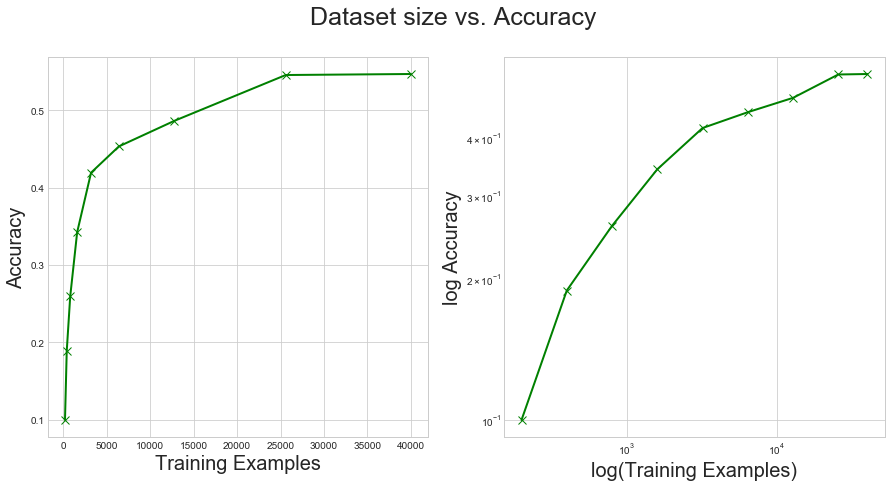

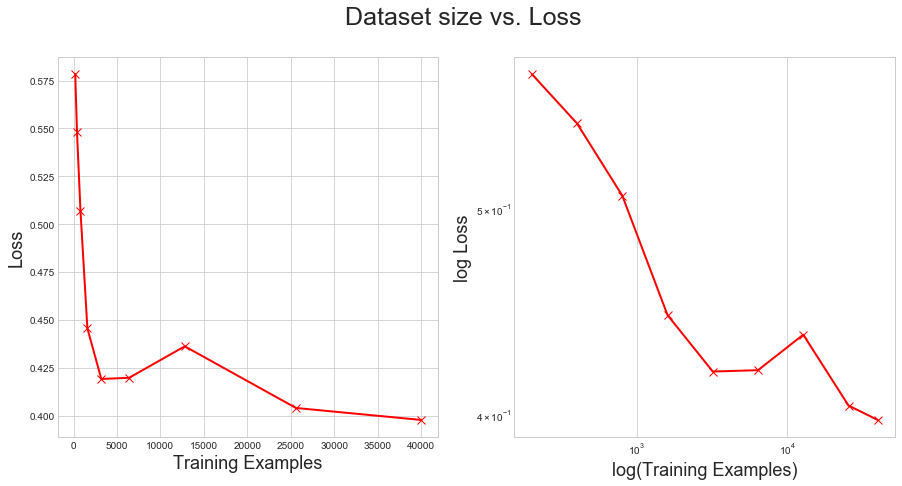

In [26]:
plot_results(test_acc, test_loss)
plt.show()

# Experiment 2
The best hyperparameter for each model depends critically upon the dataset size. We're going to do a little hyperparamter search using [random search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf). 

In [71]:
def random_hyperparamters():
    """ Returns a random sampling of hyperparameters."""
    
    hyperparam_dict = {}
    
    hyperparam_dict['lr'] = 10 ** np.random.uniform(-6, -1)
    hyperparam_dict['weight_decay'] = 10 ** np.random.uniform(-6, -3)
    hyperparam_dict['momentum'] = 10 ** np.random.uniform(-1, 0)
    
    hyperparam_dict['conv1_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv2_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['fc1_size'] = int(np.random.uniform(30,200))
    hyperparam_dict['fc2_size'] = int(np.random.uniform(30,200))

    return hyperparam_dict

def deeper_random_hyperparamters():
    """ Returns a random sampling of hyperparameters."""
    
    hyperparam_dict = {}
    
    hyperparam_dict['lr'] = 10 ** np.random.uniform(-6, -1)
    hyperparam_dict['weight_decay'] = 10 ** np.random.uniform(-6, -2)
    hyperparam_dict['momentum'] = 10 ** np.random.uniform(-1, 0)
    
    hyperparam_dict['conv1_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv2_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv3_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv4_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv5_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv6_size'] = int(np.random.uniform(10,100))
    
    hyperparam_dict['fc1_size'] = int(np.random.uniform(30,200))
    hyperparam_dict['fc2_size'] = int(np.random.uniform(30,200))

    return hyperparam_dict

## Hyperparameter search for each dataset size

In [72]:
test_acc = {}
val_acc = {}
train_acc = {}
test_loss = {}

# Testing parameters
n_searches = 2
n_epochs = 1
n_val = 10

# Real parameters
n_searches = 20
n_epochs = 15
n_val = 500


for train_size in dataset_size:
    print('Training with subset %1.4f, which is %d images'%(train_size, train_size*total_train))
    
    test_acc[train_size] = []
    test_loss[train_size] = []
    val_acc[train_size] = []
    train_acc[train_size] = []
    
    for trial in range(n_searches):
        
        hyperparam_dict = random_hyperparamters()
        print(hyperparam_dict)
        
        net = Net(hyperparam_dict)
        
        net, loss_list, val_list = train_model(net, trainset_loaders[train_size], valloader, n_val, n_epochs=n_epochs,
                                              lr=hyperparam_dict['lr'], 
                                               momentum=hyperparam_dict['momentum'], 
                                               weight_decay=hyperparam_dict['weight_decay']
                                              )

        test_acc[train_size].append((hyperparam_dict, accuracy))
        test_loss[train_size].append((hyperparam_dict, loss)) 
        val_acc[train_size].append((hyperparam_dict, val_list)) 
        train_acc[train_size].append((hyperparam_dict, loss_list))


        torch.save(net, 'trainset_%d_images_trial%d_val_loss_%1.2f.model'%((train_size*total_train), trial, val_list[-1]))
        torch.save(hyperparam_dict, 'trainset_%d_images_trial%d_val_loss_%1.2f.hparams'%((train_size*total_train), trial, val_list[-1]))
        
        del net # Attempt to free-up memory!

Training with subset 0.0050, which is 200 images
{'lr': 1.5508769329851e-05, 'weight_decay': 0.0005467689562194923, 'momentum': 0.3249750314657417, 'conv1_size': 75, 'conv2_size': 42, 'fc1_size': 196, 'fc2_size': 74}
Inside training, model ID 4804244256
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42, 5, 5])
torch.Size([4, 42,

Process Process-10424:
Process Process-10423:
Traceback (most recent call last):
KeyboardInterrupt
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/archy/anaconda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/archy/anaconda/envs/pytorch/lib

KeyboardInterrupt: 

### Load the best model for each dataset size

In [546]:
test_acc, test_loss = test_best_saved_model(dataset_size)

Loaded model trainset_200_images_trial7_val_loss_2.16.model
Accuracy of the network on the 10000 test images: 20 %
Loaded model trainset_400_images_trial1_val_loss_1.98.model
Accuracy of the network on the 10000 test images: 28 %
Loaded model trainset_800_images_trial0_val_loss_1.93.model
Accuracy of the network on the 10000 test images: 29 %
Loaded model trainset_1600_images_trial2_val_loss_1.61.model
Accuracy of the network on the 10000 test images: 43 %
Loaded model trainset_3200_images_trial7_val_loss_1.59.model
Accuracy of the network on the 10000 test images: 42 %
Loaded model trainset_6400_images_trial0_val_loss_1.38.model
Accuracy of the network on the 10000 test images: 51 %
Loaded model trainset_12800_images_trial0_val_loss_1.38.model
Accuracy of the network on the 10000 test images: 60 %
Loaded model trainset_25600_images_trial4_val_loss_1.07.model
Accuracy of the network on the 10000 test images: 63 %
Loaded model trainset_40000_images_trial15_val_loss_1.00.model
Accuracy o

## Dataset size effects, with hyperparameter tuning

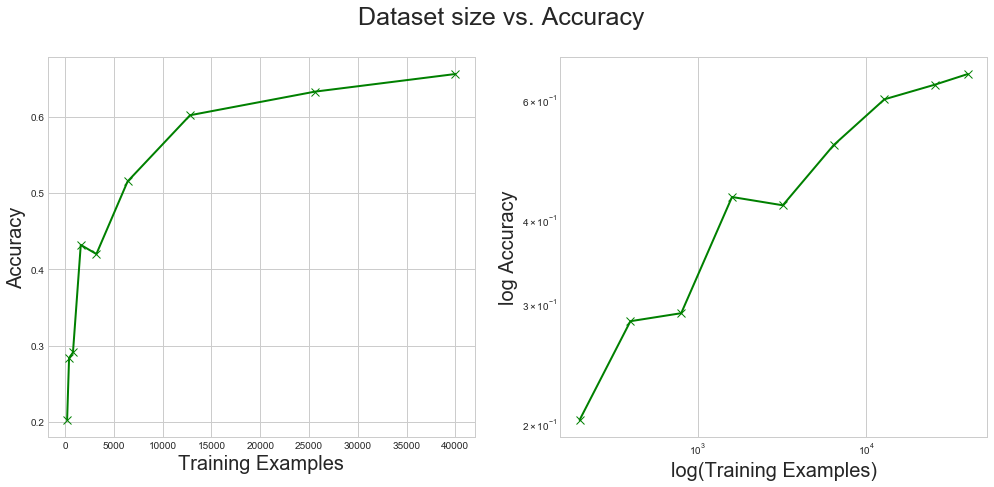

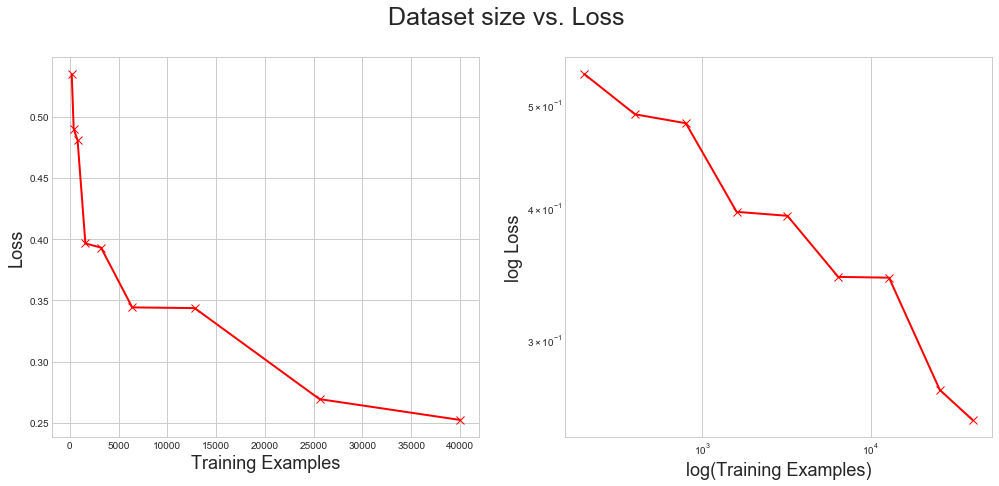

In [586]:
plot_results(test_acc, test_loss)

# Repeat the process for a deeper net

In [ ]:
test_acc = {}
val_acc = {}
train_acc = {}
test_loss = {}

# Testing parameters
n_searches = 2
n_epochs = 1
n_val = 10

# Real parameters
n_searches = 20
n_epochs = 15
n_val = 500


for train_size in dataset_size:
    print('Training with subset %1.4f, which is %d images'%(train_size, train_size*total_train))
    
    test_acc[train_size] = []
    test_loss[train_size] = []
    val_acc[train_size] = []
    train_acc[train_size] = []
    
    for trial in range(n_searches):
        
        hyperparam_dict = deeper_random_hyperparamters()
        print(hyperparam_dict)
        
        net = DeeperNet(hyperparam_dict)
        
        net, loss_list, val_list = train_model(net, trainset_loaders[train_size], valloader, n_val, n_epochs=n_epochs,
                                              lr=hyperparam_dict['lr'], 
                                               momentum=hyperparam_dict['momentum'], 
                                               weight_decay=hyperparam_dict['weight_decay']
                                              )

        test_loss[train_size].append((hyperparam_dict, loss)) 
        val_acc[train_size].append((hyperparam_dict, val_list)) 
        train_acc[train_size].append((hyperparam_dict, loss_list))


        torch.save(net, 'deeperNet_trainset_%d_images_trial%d_val_loss_%1.2f.model'%((train_size*total_train), trial, val_list[-1]))
        torch.save(hyperparam_dict, 'deeperNet_trainset_%d_images_trial%d_val_loss_%1.2f.hparams'%((train_size*total_train), trial, val_list[-1]))
        
        del net # Attempt to free-up memory!

Training with subset 0.0050, which is 200 images
{'lr': 0.0002415751408154045, 'weight_decay': 0.00039821993121162555, 'momentum': 0.4394040329100565, 'conv1_size': 53, 'conv2_size': 12, 'conv3_size': 22, 'conv4_size': 95, 'conv5_size': 45, 'conv6_size': 48, 'fc1_size': 78, 'fc2_size': 117}
Inside training, model ID 4804168728
Epoch 0 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.02 minutes for training, 0.04 for eval.
Found better model
Epoch 1 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.04 for eval.
Epoch 2 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.04 for eval.
Epoch 3 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.05 for eval.
Epoch 4 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.05 for eval.
Epoch 5 done, avg_train_loss=2.35, avg_val_loss=2.30, batches=49 
 Took 0.01 minut

/Users/archy/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type DeeperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 done, avg_train_loss=2.36, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.04 for eval.
Found better model
Epoch 1 done, avg_train_loss=2.36, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.03 for eval.
Found better model
Epoch 2 done, avg_train_loss=2.36, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.04 for eval.
Epoch 3 done, avg_train_loss=2.36, avg_val_loss=2.30, batches=49 
 Took 0.01 minutes for training, 0.03 for eval.
Epoch 4 done, avg_train_loss=2.36, avg_val_loss=2.31, batches=49 
 Took 0.01 minutes for training, 0.03 for eval.
Finished Training
Returning net with 2.304 loss
{'lr': 0.027469524382294046, 'weight_decay': 1.1285108933336589e-05, 'momentum': 0.5294457327847325, 'conv1_size': 94, 'conv2_size': 87, 'conv3_size': 63, 'conv4_size': 72, 'conv5_size': 43, 'conv6_size': 22, 'fc1_size': 145, 'fc2_size': 31}
Inside training, model ID 4804168728
Epoch 0 done, avg_train_loss=2.35, avg_val_loss=2.31, batches=49 

In [70]:
d_test_acc, d_test_loss = test_best_saved_model(dataset_size, regexp='deeperNet_trainset_%d_images*.model')

Loaded model deeperNet_trainset_200_images_trial11_val_loss_2.30.model
Test UID is 4834564864
Accuracy of the network on the 10000 test images: 10 %
Loaded model deeperNet_trainset_400_images_trial19_val_loss_2.30.model
Test UID is 4786004208
Accuracy of the network on the 10000 test images: 10 %
Loaded model deeperNet_trainset_800_images_trial0_val_loss_2.30.model
Test UID is 4804167384
Accuracy of the network on the 10000 test images: 10 %
Loaded model deeperNet_trainset_1600_images_trial0_val_loss_2.30.model
Test UID is 4804167944
Accuracy of the network on the 10000 test images: 10 %
Loaded model deeperNet_trainset_3200_images_trial19_val_loss_1.77.model
Test UID is 4791583856
Accuracy of the network on the 10000 test images: 35 %
Loaded model deeperNet_trainset_6400_images_trial11_val_loss_1.60.model
Test UID is 4786004208
Accuracy of the network on the 10000 test images: 38 %
Loaded model deeperNet_trainset_12800_images_trial16_val_loss_1.29.model
Test UID is 4834566040
Accuracy 

In [55]:
x = Variable(data[0])

In [63]:
net = DeeperNet()
net.forward(x)

torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 5, 5])
torch.Size([4, 32, 4, 4])
torch.Size([4, 32, 3, 3])
torch.Size([4, 64, 2, 2])
torch.Size([4, 128, 1, 1])


Variable containing:
 0.0169  0.0857  0.0492 -0.0714 -0.1155 -0.0234  0.0357 -0.0483 -0.0799 -0.0246
[torch.FloatTensor of size 1x10]

In [50]:
y = Variable(data[1])

In [51]:
y

Variable containing:
 8
 6
 8
 0
[torch.LongTensor of size 4]